# Network Analysis

This notebook establishes the **baseline structural properties** of London's rapid transit network (Underground + DLR + Overground). It serves two purposes:

1. **Validation**: Confirm the network graph is correctly constructed and behaves as expected (central interchanges dominate centrality rankings, network is connected, etc.)

2. **Context for later hypotheses**: Compute standard network metrics that will be compared against Thames-specific metrics (CRREB, CRP) in subsequent notebooks.

**Key outputs:**
- Node and edge centrality rankings (betweenness, closeness, degree)
- Spectral properties (algebraic connectivity λ₂, Fiedler vector)
- Community structure and alignment with Thames bank partition

**Research question context:**  
We will show that *standard centrality metrics do not identify Thames crossings as exceptional* motivating the need for cross-river-restricted metrics developed in Notebook 02.

In [ ]:
import logging

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib.collections import LineCollection
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from networkx.algorithms.community import louvain_communities  # type: ignore
from scipy.stats import entropy
from sklearn.metrics import mutual_info_score
from src.core.config import SEED, configure_logging, get_paths
from src.core.data_loaders import AnalysisDataset, load_analysis_dataset
from src.graph.spectral import compute_algebraic_connectivity_and_fiedler
from src.vis.vis_utils import LondonMapPlotter, create_edge_segments, prepare_station_geometries

LOGGER = logging.getLogger(__name__)

### **Setup and Configuration**

We load the analysis dataset with the following settings:
- **`use_gcc=True`**: Analyse only the Giant Connected Component (ensures all shortest-path metrics are well-defined)
- **`compute_weighted=True`**: Compute distance-weighted variants alongside unweighted metrics
- **`top_k_nodes/edges`**: Number of top-ranked nodes/edges to highlight in visualisations

The dataset loader validates schema consistency and handles the spatial enrichment (bank labels and Thames-crossing labels) needed for later analyses.

In [ ]:
configure_logging()
p = get_paths()

out_dir = p.data_analysis / "01_network_metrics"
out_dir.mkdir(parents=True, exist_ok=True)

p.processed_metrics.mkdir(parents=True, exist_ok=True)
p.docs.mkdir(parents=True, exist_ok=True)

In [ ]:
use_gcc = True
compute_weighted = True
top_k_nodes = 15
top_k_edges = 20

In [ ]:
data: AnalysisDataset = load_analysis_dataset(
        p,
        use_gcc=use_gcc,
        validate_schemas=True,
        load_spatial=True,
        weight_col=("distance_m" if compute_weighted else None),
    )

2025-12-25 19:45:12,138 | INFO | src.core.data_loaders | Loading core transit network data...
2025-12-25 19:45:12,163 | INFO | src.core.data_loaders | Core data validation passed
2025-12-25 19:45:12,163 | INFO | src.core.data_loaders | Loading spatial enrichment data...
2025-12-25 19:45:12,171 | INFO | src.core.data_loaders | Spatial data validation passed
2025-12-25 19:45:12,173 | INFO | src.core.data_loaders | Loading equity analysis data...
2025-12-25 19:45:12,177 | INFO | src.core.data_loaders | Equity data validation passed
2025-12-25 19:45:12,178 | INFO | src.core.data_loaders | Building network graph (use_gcc=True)...
2025-12-25 19:45:12,193 | INFO | src.core.data_loaders | Dataset loaded successfully: 397 stations, 467 edges, GCC=397 (100.0%)


In [ ]:
data.stations.columns, data.edges.columns, data.station_bank.columns

(Index(['station_id', 'name', 'lat', 'lon', 'modes', 'stop_type', 'zone',
        'naptan_ids', 'hub_naptan_code', 'ics_ids'],
       dtype='object'),
 Index(['u', 'v', 'line_ids', 'modes', 'directions', 'route_names',
        'distance_m'],
       dtype='object'),
 Index(['station_id', 'bank', 'nearest_river_northing_m'], dtype='object'),
 Index(['station_id', 'lsoa_code', 'method', 'distance_m'], dtype='object'))

In [ ]:
plotter = LondonMapPlotter.from_paths(
        boundary_gpkg=p.data_raw / "ons_regions_2021_en_bgc.gpkg",
        river_geojson=p.data_raw / "thames_centerline.geojson",
    )

### **Centrality Analysis**

Centrality metrics quantify the "importance" of nodes and edges in a network

#### Node Centralities

| Metric | Definition | Interpretation |
|--------|------------|----------------|
| **Degree** | Number of adjacent edges | Local connectivity; high at interchanges |
| **Closeness** | Inverse of mean shortest-path distance to all other nodes | How quickly a station can reach the rest of the network |
| **Betweenness** | Fraction of all shortest paths passing through the node | Bottleneck potential; high where paths converge |

#### Edge Centrality

| Metric | Definition | Interpretation |
|--------|------------|----------------|
| **Edge betweenness** | Fraction of all shortest paths passing through the edge | Critical links where many journeys must pass |

### Weighted vs Unweighted

- **Unweighted**: All edges have equal cost (1 hop); measures topological structure
- **Weighted** (`distance_m`): Edge cost is geographic distance; approximates travel time

In [ ]:
G = data.graph
Gw = data.graph_weighted

In [ ]:
nodes = sorted(G.nodes())

# Node centralities
degree = dict(G.degree())
closeness = nx.closeness_centrality(G)
betweenness = nx.betweenness_centrality(G, normalized=True)

closeness_w, betweenness_w = {}, {}
if Gw is not None:
    closeness_w = nx.closeness_centrality(Gw, distance="weight")
    betweenness_w = nx.betweenness_centrality(Gw, normalized=True, weight="weight")

cn = pd.DataFrame({
    "station_id": nodes,
    "degree": [degree.get(n, 0) for n in nodes],
    "closeness": [closeness.get(n, 0.0) for n in nodes],
    "betweenness": [betweenness.get(n, 0.0) for n in nodes],
    "closeness_w": [closeness_w.get(n, pd.NA) for n in nodes],
    "betweenness_w": [betweenness_w.get(n, pd.NA) for n in nodes],
})

# Edge centrality
edge_bt = nx.edge_betweenness_centrality(G, normalized=True)
edge_bt_w = {}
if Gw is not None:
    edge_bt_w = nx.edge_betweenness_centrality(Gw, normalized=True, weight="weight")

rows = []
for (u, v), val in edge_bt.items():
    u, v = (u, v) if u <= v else (v, u)
    rows.append({
        "u": u,
        "v": v,
        "edge_betweenness": val,
        "edge_betweenness_w": edge_bt_w.get((u, v), edge_bt_w.get((v, u), pd.NA)),
    })

ce = pd.DataFrame(rows)
if not ce.empty:
    ce = ce.sort_values(
        ["edge_betweenness", "u", "v"], ascending=[False, True, True]
    ).reset_index(drop=True)


In [ ]:
print(f"n_nodes_input: {float(data.stations.shape[0])}")
print(f"n_edges_input: {float(data.edges.shape[0])}")
print(f"n_nodes_used: {float(G.number_of_nodes())}")
print(f"n_edges_used: {float(G.number_of_edges())}")
print(f"use_gcc: {float(1.0 if use_gcc else 0.0)}")
print(f"weighted: {float(1.0 if Gw is not None else 0.0)}")

n_nodes_input: 397.0
n_edges_input: 467.0
n_nodes_used: 397.0
n_edges_used: 467.0
use_gcc: 1.0
weighted: 1.0


All **397 nodes** and **467 edges** have been scored. The network is fully connected (`use_gcc=True` with 100% coverage), so no nodes were excluded from the centrality calculations.

In [ ]:
cn.head()

,station_id,degree,closeness,betweenness,closeness_w,betweenness_w
0,1000002,4,0.093462,0.071501,0.000058,0.090679
1,1000003,2,0.121622,0.006832,0.000085,0.006048
2,1000004,3,0.122373,0.009105,0.000086,0.009232
3,1000005,2,0.078540,0.018657,0.000047,0.029472
4,1000007,2,0.121212,0.002575,0.000086,0.001943


In [ ]:
ce.head()

,u,v,edge_betweenness,edge_betweenness_w
0,1000080,1000138,0.317158,0.086673
1,1000138,1000226,0.220754,0.046371
2,1000080,1000235,0.207409,0.062540
3,1000025,1000235,0.192495,0.089802
4,1000080,1000129,0.190487,0.066076


In [ ]:
gcc_nodes = {str(n) for n in data.gcc_nodes}
cn["in_gcc"] = cn["station_id"].astype(str).isin(gcc_nodes)

In [ ]:
assert cn['in_gcc'].value_counts().loc[True] / len(cn) > 0.9

Centrality scores are enriched with station metadata (name, zone, bank) to enable:
- Human-readable labels in visualisations
- Stratified analysis by zone or bank in later notebooks

In [ ]:
cn = (
    cn
    .merge(data.stations[["station_id", "name", "zone"]], on="station_id", how="left")
    .merge(data.station_bank[["station_id", "bank"]], on="station_id", how="left")
)


In [ ]:
cn.head()

,station_id,degree,closeness,betweenness,closeness_w,betweenness_w,in_gcc,name,zone,bank,lsoa_code
0,1000002,4,0.093462,0.071501,0.000058,0.090679,True,Acton Town Underground Station,3.0,north,E01001358
1,1000003,2,0.121622,0.006832,0.000085,0.006048,True,Aldgate Underground Station,1.0,north,E01000005
2,1000004,3,0.122373,0.009105,0.000086,0.009232,True,Aldgate East Underground Station,1.0,north,E01035687
3,1000005,2,0.078540,0.018657,0.000047,0.029472,True,Alperton Underground Station,4.0,north,E01000632
4,1000007,2,0.121212,0.002575,0.000086,0.001943,True,Angel Underground Station,1.0,north,E01035655


In [ ]:
ce = (
    ce
    .merge(
        data.edges[["u", "v", "distance_m", "line_ids", "modes"]],
        on=["u", "v"],
        how="left",
    )
    .merge(
        data.edge_crossing[["u", "v", "is_thames_crossing"]],
        on=["u", "v"],
        how="left",
    )
)


In [ ]:
ce.head()

,u,v,edge_betweenness,edge_betweenness_w,distance_m,line_ids,modes,is_thames_crossing
0,1000080,1000138,0.317158,0.086673,1510.929087,elizabeth,elizabeth-line,False
1,1000138,1000226,0.220754,0.046371,6150.907669,elizabeth,elizabeth-line,False
2,1000080,1000235,0.207409,0.062540,1851.201993,elizabeth,elizabeth-line,False
3,1000025,1000235,0.192495,0.089802,1342.069708,elizabeth,elizabeth-line,False
4,1000080,1000129,0.190487,0.066076,1784.960134,circle;hammersmith-city;metropolitan,tube,False


In [ ]:
out_nodes = out_dir / "centrality_nodes.csv"
out_edges = out_dir / "centrality_edges.csv"
cn.to_csv(out_nodes, index=False)
ce.to_csv(out_edges, index=False)

In [ ]:
stations_gdf = prepare_station_geometries(data.stations.dropna(subset=["lon", "lat"]).copy())


In [ ]:
base_edges = data.edges[["u", "v"]].copy()
base_edges["u"] = base_edges["u"].astype(str)
base_edges["v"] = base_edges["v"].astype(str)
base_segments = create_edge_segments(stations_gdf, base_edges)

top_edges = ce.sort_values("edge_betweenness_w", ascending=False).head(top_k_edges)[["u", "v"]].copy()
top_edges["u"] = top_edges["u"].astype(str)
top_edges["v"] = top_edges["v"].astype(str)
top_segments = create_edge_segments(stations_gdf, top_edges)

top_nodes = (
        cn
        .sort_values("betweenness", ascending=False)
        .head(top_k_nodes)[["station_id"]]
        .copy()
    )

**Centrality Map - Highlights Top Nodes & Top Edges**


This map highlights:
- **Red nodes**: Top 15 stations by betweenness centrality
- **Blue edges**: Top 20 edges by weighted edge betweenness

We expect to see central London interchanges (Bank, King's Cross, Liverpool Street) dominating; this is a sanity check that the network behaves as expected.

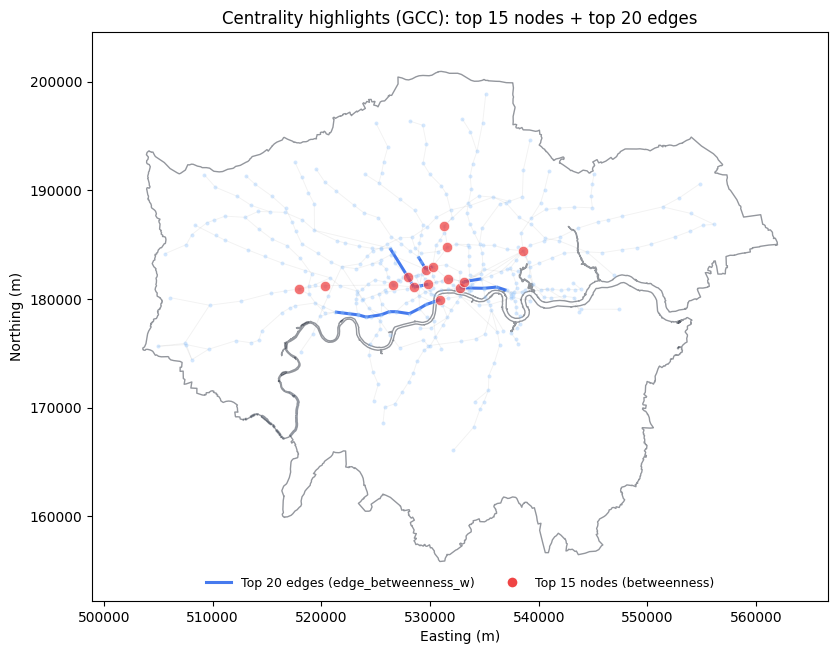

In [ ]:
# Get top node ids as strings for highlight mask
top_node_ids = set(top_nodes["station_id"].astype(str))

# Setup base map with London boundaries and Thames
fig_c_map, ax = plotter.setup_london_axes()

# Plot all network edges 
ax.add_collection(
    LineCollection(
        base_segments,
        colors=(0, 0, 0, 0.05),
        linewidths=0.7,
        zorder=3,
    )
)

# Plot top-k highlighted edges (as bold blue)
ax.add_collection(
    LineCollection(
        top_segments,
        colors=(0.145, 0.388, 0.922, 0.85),
        linewidths=2.2,
        zorder=4,
    )
)

# Plot all station nodes as fainter blue dots
ax.scatter(
    stations_gdf.geometry.x,
    stations_gdf.geometry.y,
    s=8,
    color="#93c5fd",
    alpha=0.40,
    linewidths=0,
    zorder=5,
)

# Highlight top-k betweenness nodes in red
highlight_mask = stations_gdf["station_id"].astype(str).isin(top_node_ids)
if highlight_mask.any():
    highlight_gdf = stations_gdf[highlight_mask]
    ax.scatter(
        highlight_gdf.geometry.x,
        highlight_gdf.geometry.y,
        s=55,
        color="#ef4444",
        alpha=0.75,
        linewidths=0.6,
        edgecolors="white",
        zorder=6,
    )

ax.set_title(
    f"Centrality highlights ({'GCC' if use_gcc else 'full graph'}): top {top_k_nodes} nodes + top {top_k_edges} edges"
)

# Custom legend for clarity
ax.legend(
    handles=[
        Line2D(
            [0], [0],
            lw=2.2,
            color=(0.145, 0.388, 0.922, 0.85),
            label=f"Top {top_k_edges} edges (edge_betweenness_w)",
        ),
        Line2D(
            [0], [0],
            marker="o",
            color="w",
            markerfacecolor="#ef4444",
            markeredgecolor="white",
            markersize=8,
            linestyle="None",
            label=f"Top {top_k_nodes} nodes (betweenness)",
        ),
    ],
    loc="lower center",
    ncol=2,
    frameon=False,
    fontsize=9,
)

plt.show()

**Interpretation:**  
The top-ranked nodes cluster in central London, particularly along the east-west Elizabeth Line corridor and at major interchange hubs. This is consistent with these stations serving as convergence points for multiple lines.

**Key observation for later:** Note the absence of obvious Thames-crossing edges in the top-ranked set, the highest-betweenness edges are primarily *within* central London (e.g., Gloucester Road–South Kensington, Euston–King's Cross). This motivates the need for a *cross-river-restricted* metric (CRREB) to isolate Thames-specific structural importance.

In [ ]:
def clean_station_label(name: str) -> str:
    if pd.isna(name):
        return "Unknown"

    name = str(name).strip()
    if not name:
        return "Unknown"

    # Remove common suffixes that clutter plots (order matters - longer first)
    suffixes_to_remove = [
        " Rail Station", " Railway Station", " Station",
        " Underground", " Tube", " (London)", " DLR", "(Dist&Picc Line)"
    ]

    for suffix in suffixes_to_remove:
        if name.endswith(suffix):
            name = name[:-len(suffix)]

    # Limit length for readability
    if len(name) > 40:
        name = name[:40] + "..."

    return name

In [ ]:
edge_score_col="edge_betweenness_w"

In [ ]:
cn_top_k = cn.sort_values("betweenness", ascending=False).head(top_k_nodes).copy()
ce_top_k = ce.sort_values(edge_score_col, ascending=False).head(top_k_edges).copy()

/tmp/ipykernel_62914/2857235958.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, 1, 0.95])


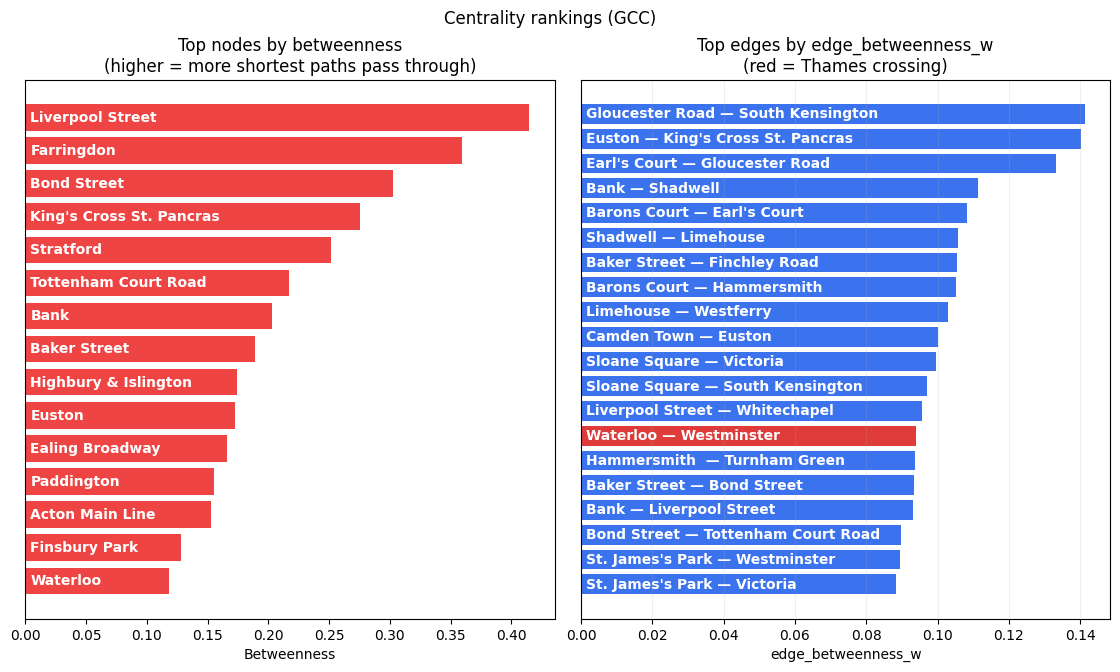

In [ ]:
fig, (ax_nodes, ax_edges) = plt.subplots(
    1, 2,
    figsize=(14, 7),
    gridspec_kw={"wspace": 0.05}
)

# Nodes
cn_top_k["label"] = cn_top_k.get("name", cn_top_k["station_id"]).astype(str).map(clean_station_label)
cn_bar = cn_top_k.sort_values("betweenness", ascending=True)
node_vals = cn_bar["betweenness"].astype(float).to_numpy()
node_labels = cn_bar["label"].tolist()

node_bars = ax_nodes.barh(range(len(node_labels)), node_vals, color="#ef4444")
ax_nodes.set_title("Top nodes by betweenness\n(higher = more shortest paths pass through)")
ax_nodes.set_xlabel("Betweenness")
ax_nodes.set_yticks([])

node_max = float(node_vals.max()) if len(node_vals) else 1.0
node_xpad = node_max * 0.01
for bar, lab in zip(node_bars, node_labels):
    y = bar.get_y() + bar.get_height() / 2.0
    txt = str(lab)
    
    ax_nodes.text(
        node_xpad,
        y,
        txt,
        va="center",
        ha="left",
        color="white",
        fontweight="bold",
        clip_on=True,
        zorder=10,
    )

# Edges
name_map = cn.set_index("station_id").get("name")

nm = name_map.astype(str).map(clean_station_label).to_dict()
ce_top_k["u_name"] = ce_top_k["u"].astype(str).map(nm).fillna(ce_top_k["u"].astype(str))
ce_top_k["v_name"] = ce_top_k["v"].astype(str).map(nm).fillna(ce_top_k["v"].astype(str))
ce_top_k["label"] = ce_top_k["u_name"].astype(str) + " — " + ce_top_k["v_name"].astype(str)

ce_bar = ce_top_k.sort_values(edge_score_col, ascending=True)
edge_vals = ce_bar[edge_score_col].astype(float).to_numpy()
edge_labels = ce_bar["label"].tolist()

colors = [
    "#dc2626" if bool(x) else "#2563eb"
    for x in ce_bar["is_thames_crossing"].fillna(False).tolist()
]

edge_bars = ax_edges.barh(range(len(edge_labels)), edge_vals, color=colors, alpha=0.90)
ax_edges.set_title(f"Top edges by {edge_score_col}\n(red = Thames crossing)")
ax_edges.set_xlabel(edge_score_col)
ax_edges.grid(axis="x", alpha=0.2)
ax_edges.set_yticks([])

edge_max = float(edge_vals.max()) if len(edge_vals) else 1.0
edge_xpad = edge_max * 0.01
for bar, lab in zip(edge_bars, edge_labels):
    y = bar.get_y() + bar.get_height() / 2.0
    txt = str(lab)

    ax_edges.text(
        edge_xpad,
        y,
        txt,
        va="center",
        ha="left",
        color="white",
        fontweight="bold",
    )

fig.suptitle("Centrality rankings (GCC)", y=0.98)
fig.tight_layout(rect=[0, 0, 1, 0.95]) 

**Key finding:**  
Standard edge betweenness does **not** flag Thames crossings as exceptional. The top-ranked edges are central trunk connections (Gloucester Road–South Kensington, Euston–King's Cross, etc.), with only **1 crossing visible in the top 20** (Waterloo–Westminster).

In [ ]:
cn_top_k["type"] = "node"
ce_top_k["type"] = "edge"

top_nodes_edges = pd.concat(
    [
        cn_top_k[
            [
                "type",
                "station_id",
                "name",
                "zone",
                "bank",
                "betweenness",
                "closeness",
                "degree",
            ]
        ],
        ce_top_k[
            [
                "type",
                "u",
                "v",
                "line_ids",
                "modes",
                "distance_m",
                "is_thames_crossing",
                edge_score_col,
            ]
        ].rename(columns={edge_score_col: "edge_betweenness"}),
    ],
    ignore_index=True,
    sort=False,
)
out_top = out_dir / "top_nodes_edges.csv"
top_nodes_edges.to_csv(out_top, index=False)

### **Spectral Analysis**

Spectral methods analyse the eigenvalues and eigenvectors of the graph Laplacian matrix to reveal global structural properties.

**Graph Laplacian ($L$):**  
$L = D - A$, where $D$ is the degree matrix and $A$ is the adjacency matrix.

**Algebraic Connectivity ($\lambda_2$):**  
The second-smallest eigenvalue of $L$. It measures how "easy" it is to disconnect the graph:
- $\lambda_2 = 0$ → graph is disconnected
- Small $\lambda_2$ → graph has a structural bottleneck (near-cut)
- Large $\lambda_2$ → graph is well-connected throughout

**Fiedler Vector:**  
The eigenvector corresponding to $\lambda_2$. Its sign pattern reveals the graph's "natural" bipartition, nodes with similar Fiedler values are structurally closer.


**If the Thames acts as the network's primary structural bottleneck, we would expect the Fiedler vector to show a gradient aligned with north-south bank labels. We test this below.**

In [ ]:
res = compute_algebraic_connectivity_and_fiedler(data.graph, weight=None)

In [ ]:
print({
    "n_nodes_gcc": int(data.graph.number_of_nodes()),
    "n_edges_gcc": int(data.graph.number_of_edges()),
    "lambda2": float(res.lambda2),
})

{'n_nodes_gcc': 397, 'n_edges_gcc': 467, 'lambda2': 0.009751737540846213}


In [ ]:
fiedler_vector = pd.DataFrame(
    [{"station_id": sid, "fiedler": val} for sid, val in res.fiedler_vector.items()]
)
fiedler_vector

,station_id,fiedler
0,1000002,0.064159
1,1000003,-0.026193
2,1000004,-0.028355
3,1000005,0.086890
4,1000007,-0.011426
...,...,...
392,1003006,-0.041783
393,1003007,-0.040558
394,1003008,-0.052855
395,1003009,-0.039320


In [ ]:
stations_gdf_w_fiedler = stations_gdf.merge(fiedler_vector[["station_id", "fiedler"]], on="station_id", how="inner")

In [ ]:
out_fied = out_dir / "stations_fiedler.csv"
stations_gdf_w_fiedler.to_csv(out_fied, index=False)

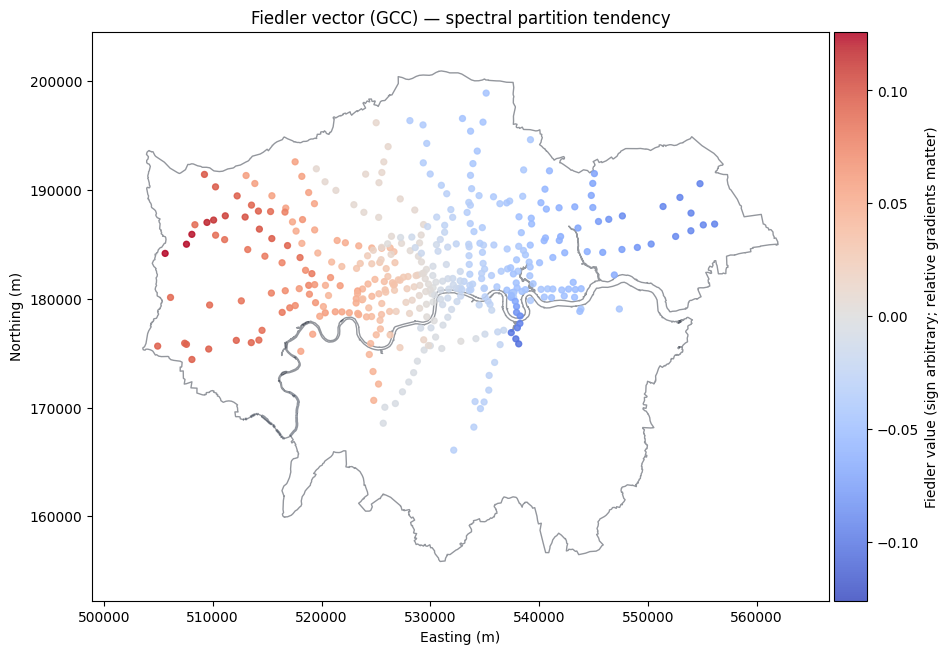

In [ ]:
fig_fiedler, ax = plotter.setup_london_axes(figsize=(10, 10))
vals = stations_gdf_w_fiedler["fiedler"].astype(float).to_numpy()
vmax = float(np.nanmax(np.abs(vals))) if len(vals) else 1.0
sc = ax.scatter(
    stations_gdf_w_fiedler.geometry.x,
    stations_gdf_w_fiedler.geometry.y,
    c=stations_gdf_w_fiedler["fiedler"].astype(float),
    cmap="coolwarm",
    vmin=-vmax,
    vmax=vmax,
    s=18,
    alpha=0.85,
)
ax.set_title("Fiedler vector (GCC) — spectral partition tendency")

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4.5%", pad=0.05)
cbar = fig_fiedler.colorbar(sc, cax=cax)
cbar.set_label("Fiedler value (sign arbitrary; relative gradients matter)")

**Interpretation:**  
The Fiedler gradient runs **west-to-east**, not north-to-south. This means if you had to split the network into two parts by removing the fewest edges, the optimal cut would separate east London from west London, not north bank from south bank.

**Why?** London's transit network has many parallel east-west lines (Central, District, Piccadilly, Elizabeth, etc.) but fewer continuous north-south routes. The network is structurally "thinner" in the east-west direction than across the Thames.
 
The Thames is not a *global* bottleneck (affecting all trips). However, it remains a *conditional* bottleneck: for journeys that specifically require crossing the river, the 15 crossing edges are the only options. 

This distinction is why we need CRREB (Cross-River Restricted Edge Betweenness) — standard spectral analysis averages over all trips, diluting the Thames signal. CRREB isolates cross-bank trips specifically, revealing the crossings' true structural importance.

> The network's global partition structure is not Thames-aligned, but for cross-bank travel, a small set of crossings concentrates disproportionate structural dependence.

#### Limitations and Extensions: The Thames as a Behavioral Barrier
 
These observations raise questions beyond the scope of topological analysis:
  - Do south bank residents undertake fewer cross-bank journeys than predicted by network structure alone?
  - Does network topology reinforce spatial inequalities by impeding cross-bank accessibility?
  
Future research could integrate topological metrics with:
- Empirical travel behavior data
- Accessibility models quantifying jobs or services reachable within set travel times

### **Community Detection**

**Bank Alignment Metrics**

To test whether communities respect the Thames boundary, I compute:

| Metric | Definition | Interpretation |
|--------|------------|----------------|
| **Weighted bank purity** | Average fraction of each community on its dominant bank, weighted by community size | 1.0 = all communities are single-bank; 0.5 = communities are bank-mixed |
| **NMI** (Normalised Mutual Information) | Information-theoretic measure of alignment between community labels and bank labels | 1.0 = perfect alignment; 0.0 = independent |

**Expected outcome:**  
If the Thames strongly shapes community structure, we expect high purity *and* high NMI. If communities form for other reasons (e.g., line corridors, zones), purity may be high (communities happen to be single-bank) but NMI will be low.

In [ ]:
G = data.graph
if G.number_of_nodes() == 0:
    raise ValueError("Graph has no nodes.")

# Run Louvain community detection with deterministic seed
communities_sets = louvain_communities(G, seed=SEED)

# Rank communities by size for stable ids (largest gets id=0)
communities_sorted = sorted(
    communities_sets, key=lambda c: (-len(c), sorted(str(x) for x in c)[0])
)
node_to_comm = {}
comm_to_nodes = {}
for cid, comm in enumerate(communities_sorted):
    nodes = sorted([str(n) for n in comm])
    comm_to_nodes[cid] = nodes
    for n in nodes:
        node_to_comm[n] = cid

labels = pd.DataFrame(
    [{"station_id": sid, "community_id": cid} for sid, cid in node_to_comm.items()]
)

In [ ]:
labels = labels.merge(
            data.station_bank[["station_id", "bank"]], on="station_id", how="left"
        )
labels["in_gcc"] = labels["station_id"].astype(str).isin(gcc_nodes)

In [ ]:
node_to_bank = {
    str(r["station_id"]): str(r["bank"])
    for _, r in labels.dropna(subset=["bank"]).iterrows()
}

In [ ]:
# Restrict to nodes with both labels
nodes = [
    n for n in node_to_comm.keys() if n in node_to_bank and str(node_to_bank[n]) != ""
]
comm_ids = sorted(set(node_to_comm[n] for n in nodes))
banks = sorted(set(str(node_to_bank[n]) for n in nodes))

In [ ]:
contingency = {}
for n in nodes:
    c = node_to_comm[n]
    b = str(node_to_bank[n])
    contingency[(c, b)] = contingency.get((c, b), 0) + 1

community_purity = {}
community_dominant_bank = {}
total = len(nodes)
weighted = 0.0
for c in comm_ids:
    counts = {b: contingency.get((c, b), 0) for b in banks}
    size = sum(counts.values())
    if size == 0:
        continue
    dom_bank = max(counts.items(), key=lambda kv: kv[1])[0]
    purity = counts[dom_bank] / size
    community_purity[c] = float(purity)
    community_dominant_bank[c] = dom_bank
    weighted += (size / total) * purity

# NMI calculation using sklearn/scipy
labels_comm = [node_to_comm[n] for n in nodes]
labels_bank = [str(node_to_bank[n]) for n in nodes]

mi = mutual_info_score(labels_comm, labels_bank)

comm_counts = np.array([sum(contingency.get((c, b), 0) for b in banks) for c in comm_ids])
bank_counts = np.array([sum(contingency.get((c, b), 0) for c in comm_ids) for b in banks])

h_c = entropy(comm_counts, base=None)  # natural log
h_b = entropy(bank_counts, base=None)
denom = h_c + h_b
nmi = 0.0 if denom == 0 else (2.0 * mi / denom)

In [ ]:
print(f"weighted_purity: {weighted}, nmi: {nmi}")

weighted_purity: 0.9219143576826193, nmi: 0.14646396138279233


In [ ]:
stations_gdf_w_communities = stations_gdf.merge(
    labels[["station_id", "community_id"]], on="station_id", how="inner"
)

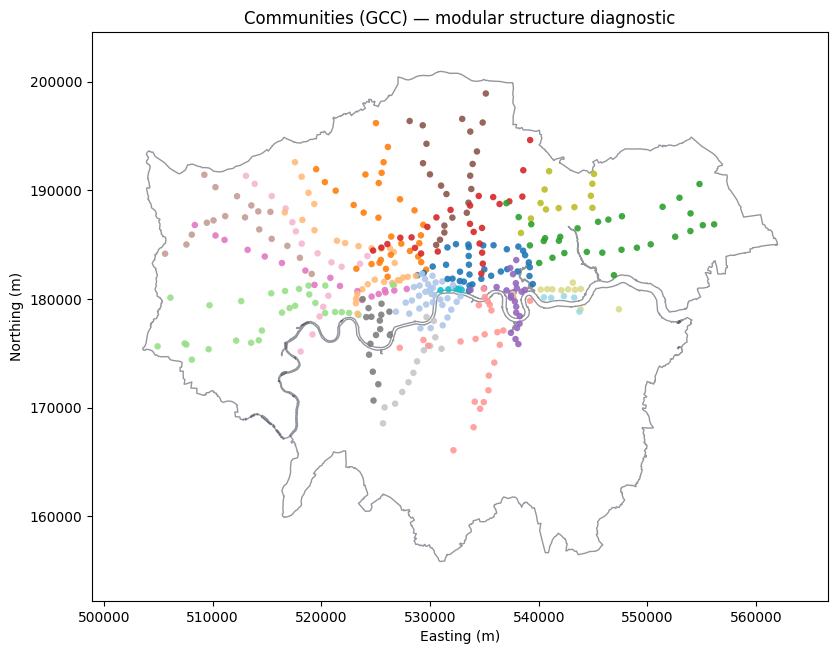

In [ ]:
fig, ax = plotter.setup_london_axes(figsize=None)

n_comms = int(stations_gdf_w_communities["community_id"].max()) + 1 
cmap = plt.get_cmap("tab20", max(n_comms, 1))
colors = [cmap(int(c) % cmap.N) for c in stations_gdf_w_communities["community_id"].astype(int).tolist()]
ax.scatter(
    stations_gdf_w_communities.geometry.x,
    stations_gdf_w_communities.geometry.y,
    c=colors,
    s=22,
    alpha=0.90,
    linewidths=0.0,
    zorder=3,
)
ax.set_title("Communities (GCC) — modular structure diagnostic")
fig_comm = fig

#### Community Detection Results

- **Number of communities:** 19
- **Weighted bank purity:** 0.922 (high)
- **NMI:** 0.146 (low)

**Interpretation:**  
Most communities are predominantly single-bank (high purity), but the bank partition is **not the dominant driver** of community structure (low NMI). Communities likely form along line corridors or geographic proximity rather than explicitly respecting the river boundary.

This reinforces the spectral finding: the Thames is not the network's primary structural organiser. Thames-specific metrics are needed to isolate the cross-river mechanism.